### Get Pelvis data - LPF + Norm (save Figure + csv)
### Get oneHot encoded Label 
### Interpolation (Univariate Interpolation)

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


from scipy.signal import butter, lfilter, filtfilt  
from scipy.interpolate import UnivariateSpline  # missing value -> np.nan -> to zero -> 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold  # 라벨 x_data, y_data 분포를 유지 (함께 fold)
import tensorflow as tf 

np.random.seed(7)
np.set_printoptions(precision=4, suppress=True)  # 과학적 표기 대신 소숫점 자리 4자리까지 표현

rootDir = "/DockerProjects/Dataset/TUG/trainSet"
expertFolder = "/" + "HMM_saveResults_date_CYJ"  # --- 변경 할 부분
viewFolder = "/" + "0_sideView"

print(" [Home Dir.] Current path", os.getcwd())  

datasetDir = rootDir + expertFolder + viewFolder
os.chdir(datasetDir) ; print(" Current workaing path [dataset] ", os.getcwd())  # -- Dataset 있는 곳으로 경로 변경 

 [Home Dir.] Current path /DockerProjects/walkCAM/tug/0_temporalCNN_wLabel
 Current workaing path [dataset]  /DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView


### Train/Test Subject Split

In [2]:
def get_subjectList(datasetDir, shuffle = False):      
    expDates = next(os.walk(datasetDir))[1]   #['2020_11_03', '2020_11_20_v1', '2020_11_20_v2', '2020_11_23', '2020_12_09', '2020_12_30']
    subject_number = 0
    subjects_list = []
    
    for dateFolder in expDates:
        dateDir = os.path.join(datasetDir, dateFolder)   # D:/바탕화면/Dataset/TUG/trainSet/2021_01_24_saveResults_최윤정/0_sideView\2020_11_03
        tmpSubjects = next(os.walk(dateDir))[1]
        subjects_list.append(tmpSubjects)  
 
    # ------ 2D -> 1D [[sub1, sub2], [sub3, sub4]] -> [sub1, sub2, sub3, sub4]
    subjects = []
    for eachSub in subjects_list:
        for sub in eachSub:
            if ".ipynb_checkpoints" == sub:
                pass
            else:
                subjects.append(sub)
                subject_number +=1

    if shuffle:
        np.random.shuffle(subjects)
        
    print(" 1D sub list: " , subjects, len(subjects))
    return subjects, subject_number

def fold_trainNames(subList, Kfold_num = 5):
    assert (Kfold_num is not 0), print("check kfold_num. should not be zero")
    Fold_results =[]
    kfold = KFold(n_splits=  Kfold_num)
    
    for trainIdx, testIdx in kfold.split(subList):
        Fold_results.append([trainIdx, testIdx])      
        
    train_Fold= []
    test_Fold = []
        
    for i in range(Kfold_num):    # bind fold pair
        tmp_train = []
        tmp_test = []
        for subIdx in range(len(subList)): 
            if subIdx in Fold_results[i][0]:  # -- K-fold train
                tmp_train.append(subList[subIdx])
               
            if subIdx in Fold_results[i][1]:  # -- K-fold test
                tmp_test.append(subList[subIdx])
          
        train_Fold.append(tmp_train)
        test_Fold.append(tmp_test)
        print("\t [process]", i, "-fold:", train_Fold[i], "\n\t\t\t   ,", test_Fold[i])
    print("\n [results]  trainSet: ", len(train_Fold[0]) , " 명 , testSet: ", len(test_Fold[0]), " 명" )
    
    return train_Fold, test_Fold


# ----------------------------> print all subjects 
# subList, numOfsubjects = get_subjectList(datasetDir, shuffle = shuffle) ; print("\n")


In [3]:
train_ratio = 0.6
valid_ratio = 0.2

shuffle = True
arbitrarySplit = False
Kfold = True
Kfold_num = 5 

numFeature = 4 # time + numPelvis = 4
numPelvis = 3 
numActions = 5
dataset_columns = numFeature + numActions

norm20 = ['bys_tug', 'cyj_tug', 'cbd_tug', 'kw' , 'pjh',     'pss', 'yjh', 'kyh' , 'lhs', 'nhs',    'bys', 'cyj', 'cbd', 'cyj2', 'jdh',   'jet', 'kch']
norm60 = ['rjh', 'NHJ_60', 'LKO_TUG', 'LSJ_TUG',    'GYH_TUG', 'KYS3_TUG','PBK_TUG','KJK_TUG', 'UMS_TUG','JJS_TUG',   'HOJ_TUG','SJJ_TUG','YSS2_TUG',   'KJH_TUG','CSY_TUG','LBL_TUG','BKS_TUG', 
            'LSC_TUG','YMR_TUG','PSM_TUG','HSN_TUG','SOS_TUG',     'LSS_TUG', 'KHM_TUG', 'LJS_TUG', 'LJE_TUG',     'KBH_TUG' ]
stroke = ['KNG_TUG', 'KSG_TUG', 'YBJ_TUG', 'RJD_TUG',  'SRK_TUG',     'KYS_TUG', 'KTS_TUG','SRH_TUG', 'HHS_TUG', 'KYS2_TUG',      'KSJ_TUG', 'KYB_TUG', 'CES_TUG', 'PCW_TUG', 'WJS_TUG',
            'HKH_TUG', 'HJY_TUG', 'SHW_TUG']

                # 정상인 (20-40대) --- 17명, 166 Trials (중복 3명 빼면 14명, 138 Trials )
                # ['bys_tug', 'cyj_tug', 'cbd_tug', 'kw' , 'pjh',     'pss', 'yjh', 'kyh' , 'lhs', 'nhs',    'bys', 'cyj', 'cbd', 'cyj2', 'jdh',   'jet', 'kch']
            
            
                # 정상인 (50-70대)  ---- 총 31명  227 Trials 
                # ['rjh', 'NHJ_60', 'YJY_TUG'(0), 'LKO_TUG', 'LSJ_TUG',    'GYH_TUG', 'KYS3_TUG','PBK_TUG','KJK_TUG', 'WHS_TUG'(0),    'UMS_TUG','JJS_TUG','HOJ_TUG','SJJ_TUG','YSS2_TUG',   'KJH_TUG','CSY_TUG','LBL_TUG','UKO_TUG'(0), 'BKS_TUG', 
                # 'LSC_TUG','YMR_TUG','PSM_TUG','HSN_TUG','SOS_TUG',     'LSS_TUG', 'KDS_TUG'(0), 'KHM_TUG', 'LJS_TUG', 'LJE_TUG',     'KBH_TUG' ]


                # 뇌졸중 (연령 X) --- 총 20 명 , 85 Trials
                # [  'BGD_TUG'(0), 'KNG_TUG', 'KSG_TUG', 'YBJ_TUG', 'RJD_TUG',    'YSS_TUG'(0), 'SRK_TUG', 'KWB_TUG'(0), 'KYS_TUG', 'KTS_TUG',    'SRH_TUG', 'YDS_TUG'(0)', 'HHS_TUG', 'KYS2_TUG', 'KSJ_TUG',      
                #    'KYB_TUG', 'CES_TUG', 'PCW_TUG', 'WJS_TUG','HKH_TUG',        'HJY_TUG', 'SHW_TUG']
    
    
    
specific_group = norm60 # -------------------------------------------------- Change This part 
numOfsubjects = len( specific_group )  
print(" Selected Group: ", "norm60", " # of Subjects : ", numOfsubjects)

if Kfold:

    print(" K-fold : ", Kfold_num)
    trainFold, testFold = fold_trainNames(subList = specific_group, Kfold_num = Kfold_num)    
else:
    np.random.shuffle(specific_group)
    
    trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
    validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
    testSub_number = numOfsubjects - trainSub_number - validSub_number

    train_subjects = specific_group[ :trainSub_number]
    valid_subjects = specific_group[ trainSub_number : (trainSub_number + validSub_number)]
    test_subjects = specific_group[ (trainSub_number+validSub_number): ]
    
    print(" No-fold --- (arbitrary) \t [results] \n\t Train 명: " ,len(train_subjects), "\n\t Valid 명: ", len(valid_subjects), "\n\t Test 명: ", len(test_subjects))
    print(" No-fold --- (arbitrary) \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
    

 Selected Group:  norm60  # of Subjects :  27
 K-fold :  5
	 [process] 0 -fold: ['PBK_TUG', 'KJK_TUG', 'UMS_TUG', 'JJS_TUG', 'HOJ_TUG', 'SJJ_TUG', 'YSS2_TUG', 'KJH_TUG', 'CSY_TUG', 'LBL_TUG', 'BKS_TUG', 'LSC_TUG', 'YMR_TUG', 'PSM_TUG', 'HSN_TUG', 'SOS_TUG', 'LSS_TUG', 'KHM_TUG', 'LJS_TUG', 'LJE_TUG', 'KBH_TUG'] 
			   , ['rjh', 'NHJ_60', 'LKO_TUG', 'LSJ_TUG', 'GYH_TUG', 'KYS3_TUG']
	 [process] 1 -fold: ['rjh', 'NHJ_60', 'LKO_TUG', 'LSJ_TUG', 'GYH_TUG', 'KYS3_TUG', 'YSS2_TUG', 'KJH_TUG', 'CSY_TUG', 'LBL_TUG', 'BKS_TUG', 'LSC_TUG', 'YMR_TUG', 'PSM_TUG', 'HSN_TUG', 'SOS_TUG', 'LSS_TUG', 'KHM_TUG', 'LJS_TUG', 'LJE_TUG', 'KBH_TUG'] 
			   , ['PBK_TUG', 'KJK_TUG', 'UMS_TUG', 'JJS_TUG', 'HOJ_TUG', 'SJJ_TUG']
	 [process] 2 -fold: ['rjh', 'NHJ_60', 'LKO_TUG', 'LSJ_TUG', 'GYH_TUG', 'KYS3_TUG', 'PBK_TUG', 'KJK_TUG', 'UMS_TUG', 'JJS_TUG', 'HOJ_TUG', 'SJJ_TUG', 'LSC_TUG', 'YMR_TUG', 'PSM_TUG', 'HSN_TUG', 'SOS_TUG', 'LSS_TUG', 'KHM_TUG', 'LJS_TUG', 'LJE_TUG', 'KBH_TUG'] 
			   , ['YSS2_TUG', 'KJH_TU

In [4]:
def get_rawData(csvFile):
    interCheck = False
    continuous_errorVal_Check = 30

    csv_data_ = np.loadtxt(csvFile, delimiter=',', dtype=str, skiprows=2, usecols=(0,1,2,3)) 
    frameNum = csv_data_[:,0].astype(np.int)  # int로 type conversion
    max_frame = len(frameNum)
    
    rawPelvis_x = np.array(frameNum).astype(np.float32)
    rawPelvis_y = np.array(frameNum).astype(np.float32)
    rawPelvis_z = np.array(frameNum).astype(np.float32)
    

    #--- if have "empty value" ---- Interpolation  
    for i, v in enumerate(csv_data_[:, 1]):
        if v == " ": 
            interCheck = True
            csv_data_[i,1] = np.nan
            csv_data_[i,2] = np.nan
            csv_data_[i,3] = np.nan
        rawPelvis_x[i] = csv_data_[i, 1].astype(np.float32)
        rawPelvis_y[i] = csv_data_[i, 2].astype(np.float32)
        rawPelvis_z[i] = csv_data_[i, 3].astype(np.float32)
  
    if interCheck: 
        w_x = np.isnan(rawPelvis_x) 
        rawPelvis_x[w_x] = 0
        Fx = UnivariateSpline(frameNum,rawPelvis_x,w=~w_x)
        newPelvis_x = Fx(frameNum)

        w_y = np.isnan(rawPelvis_y) 
        rawPelvis_y[w_y] = 0
        Fy = UnivariateSpline(frameNum,rawPelvis_y,w=~w_y)
        newPelvis_y = Fy(frameNum)

        w_z = np.isnan(rawPelvis_z) 
        rawPelvis_z[w_z] = 0
        Fz = UnivariateSpline(frameNum,rawPelvis_z,w=~w_z)
        newPelvis_z = Fz(frameNum)

    else:
        newPelvis_x = rawPelvis_x
        newPelvis_y = rawPelvis_y
        newPelvis_z = rawPelvis_z
   

    if np.max(newPelvis_z) >= 5000:
        # ----------- if have garbage value (not "empty..") ... 
        for i in range(continuous_errorVal_Check): # 30 
            newPelvis_x[np.where(np.abs(newPelvis_x[1+i:]-newPelvis_x[:-(1+i)]) > 100)[0]] = newPelvis_x[np.where(np.abs(newPelvis_x[1+i:]-newPelvis_x[:-(1+i)]) > 100)[0]-1]
            newPelvis_y[np.where(np.abs(newPelvis_y[1+i:]-newPelvis_y[:-(1+i)]) > 100)[0]] = newPelvis_y[np.where(np.abs(newPelvis_y[1+i:]-newPelvis_y[:-(1+i)]) > 100)[0]-1]
            newPelvis_z[np.where(np.abs(newPelvis_z[1+i:]-newPelvis_z[:-(1+i)]) > 100)[0]] = newPelvis_z[np.where(np.abs(newPelvis_z[1+i:]-newPelvis_z[:-(1+i)]) > 100)[0]-1]

    
    timeData = np.loadtxt(csvFile, delimiter=',', skiprows=2, dtype=np.float32, usecols=[97, 98, 99, 100]) #  # skiprows=2 (header + first data.. 가끔 첫 줄 data 이상함)
    timestamp_diff_msec = np.array([rawPelvis_x])
    for i in range(max_frame):
        before_time_msec = timeData[i-1, 0] * 60 * 60 * 1000 + timeData[i-1, 1] * 60 * 1000 +  timeData[i-1, 2] * 1000 + timeData[i-1, 3] 
        current_time_msec = timeData[i, 0] * 60 * 60 * 1000 + timeData[i, 1] * 60 * 1000 + timeData[i, 2] * 1000 + timeData[i, 3]
        if i is 0:
            timestamp_diff_msec[0, i] = 0
        else:
            timestamp_diff_msec[0, i] = int(current_time_msec - before_time_msec)
                            
        time_sum_msec = 0
        eachTimestamp_sec = np.array(frameNum, dtype=float) # sec (?,1)
        for timeIdx in range(timestamp_diff_msec.shape[1]):
            time_sum_msec = int(time_sum_msec + timestamp_diff_msec[0, timeIdx])
            eachTimestamp_sec[timeIdx] = time_sum_msec / 1000  
  
    return frameNum, eachTimestamp_sec, newPelvis_x, newPelvis_y, newPelvis_z

    
def get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max'):    
    if normMethod == "min_max":
        normPelvis_x = (pelvis_x -np.min(pelvis_x)) / ( np.max(pelvis_x) - np.min(pelvis_x))
        normPelvis_y = (pelvis_y -np.min(pelvis_y)) / ( np.max(pelvis_y) - np.min(pelvis_y))
        normPelvis_z = (pelvis_z -np.min(pelvis_z)) / ( np.max(pelvis_z) - np.min(pelvis_z))
        
    elif normMethod == "z_score":
        normPelvis_x = (pelvis_x -np.mean(pelvis_x)) / np.std(pelvis_x)
        normPelvis_y = (pelvis_y -np.mean(pelvis_y)) / np.std(pelvis_y)
        normPelvis_z = (pelvis_z -np.mean(pelvis_z)) / np.std(pelvis_z)
        
    return normPelvis_x, normPelvis_y, normPelvis_z

def get_LPFData(pelvis_x, pelvis_y, pelvis_z, cutoff_freq = 0.5, order=1):
    sampling_freq = 30
    number_of_samples = len(pelvis_y)
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = butter(order, normalized_cutoff_freq)
    Filtered_x = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_x)  # Phase shift 없음
    Filtered_y = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_y)
    Filtered_z = filtfilt(numerator_coeffs, denominator_coeffs, pelvis_z)
    return Filtered_x, Filtered_y, Filtered_z


def getLPF_PelvisData(csvFile):
    rawData = np.loadtxt(csvFile, delimiter=",")
    timestamp = rawData[:,0]
    pelvis_x = rawData[:,1]
    pelvis_y = rawData[:,2]
    pelvis_z = rawData[:,3]
    actionList = rawData[:,4:]
    return timestamp, pelvis_x, pelvis_y, pelvis_z, actionList

  
def pltSkeleton(timeSec, pelvis_x, pelvis_y, pelvis_z, saveDir, saveFile,  actLabel, addFolder="raw", actSplit=False, save=True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))
    title = addFolder + "_" + saveFile
    ax[0].set_title(title)
    ax[0].set_ylabel('Side axis(X) of Pelvis [mm]')
    ax[1].set_ylabel('Vertical axis(Y) of Pelvis [mm]')
    ax[2].set_ylabel('Depth Axis of Pelvis [mm]')
    ax[2].set_xlabel('Time [Sec]')
    ax[0].plot(timeSec, pelvis_x, "r--", lw=1, label="pelvis_x")
    ax[1].plot(timeSec, pelvis_y, "g--", lw=1, label="pelvis_y")
    ax[2].plot(timeSec, pelvis_z, "b--", lw=1, label="pelvis_z")
    
    if actSplit:
        for i in range(3):
            if i ==0:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3, label="start move")
                ax[i].axvline(x=timeSec[actLabel[1]], color='r', linestyle=":", linewidth=3, label="start walk")
                
                ax[i].axvline(x=timeSec[actLabel[2]], color='k', linestyle="--", linewidth=3, label="start turn")
                ax[i].axvline(x=timeSec[actLabel[3]], color='k', linestyle=":", linewidth=3, label="end turn")
                
                ax[i].axvline(x=timeSec[actLabel[4]], color='g', linestyle="--", linewidth=3, label="start sit")
                ax[i].axvline(x=timeSec[actLabel[5]], color='g', linestyle=":", linewidth=3, label="end sit")
            else:
                ax[i].axvline(x=timeSec[actLabel[0]], color='r', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[1]], color='k', linestyle="--", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[2]], color='g', linestyle="--", linewidth=3)

                ax[i].axvline(x=timeSec[actLabel[3]], color='r', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[4]], color='k', linestyle=":", linewidth=3)
                ax[i].axvline(x=timeSec[actLabel[5]], color='g', linestyle=":", linewidth=3)

    fig.legend()
    plt.show()
    
    if save:
        if  os.path.isfile(saveDir+"/"+title):
            os.remove(saveDir+"/"+title)
        fig.savefig(saveDir+"/"+title)
    plt.close()
           
      

In [5]:
def get_actFrameNumber(csvFile): 
    actFrame = []
    with open(csvFile, 'r', encoding='utf-8') as readCSV:
        data = readCSV.read()
        lines = data.split("\n") # lines[0] = header, [1] = act label data
        tmpLabel = lines[1].split(",")
       
        for i in range(len(tmpLabel)):           
            actFrame.append( int(tmpLabel[i].split("_")[1].split(".")[0]) ) 
        return actFrame   
    
def sliding_window(timestamp, data_x, data_y, lookback_window=8):
    time = []
    x = []
    y = []
    enc = MinMaxScaler(feature_range = (0, 1))
    enc_y = enc.fit_transform(data_y)
    for i in range(lookback_window, len(data_x)+1):
        time.append(timestamp[i-1])
        x.append(data_x[i - lookback_window:i])
        y.append(data_y[i-1])
  
    x = np.array(x)
    x = x.reshape(-1, lookback_window, numPelvis, 1)
    
    y = np.array(y)
    time = np.array(time)
   
    return time, x, y, enc

#------------------ Origin... sit, sit-to-stand, walk, turn, stand-to-sit (5action)
def convert_act2oneHot(actFrame, frameNum):
    actionList = []
    for timeIdx in range(len(frameNum)):
        if (timeIdx < actFrame[0]):  # frame Num < move start fram (sit)
            actionList.append(np.array([1, 0, 0, 0, 0],dtype=np.int))
                    # moveStartIdx ~ startWalk 까지 (sit-to-stand)
        elif (timeIdx >= actFrame[0]) and (timeIdx < actFrame[1]):
            actionList.append(np.array([0, 1, 0, 0, 0],dtype=np.int))
                    # startWalk ~ turnStartIdx 까지 (walk)
        elif (timeIdx >= actFrame[1]) and (timeIdx < actFrame[2]):
            actionList.append(np.array([0, 0, 1, 0, 0],dtype=np.int))
                    # turnStartIdx ~ turnEndIdx 까지 (turn)
        elif (timeIdx >= actFrame[2]) and (timeIdx < actFrame[3]):
            actionList.append(np.array([0, 0, 0, 1, 0],dtype=np.int))
                    # turnEndIdx ~ startSitIdx 까지 (walk)
        elif (timeIdx >= actFrame[3]) and (timeIdx < actFrame[4]):
            actionList.append(np.array([0, 0, 1, 0, 0],dtype=np.int))
                    # startSitIdx ~ moveEndIdx 까지 (stand-to-sit)
        elif (timeIdx >= actFrame[4]) and (timeIdx < actFrame[5]):
            actionList.append(np.array([0, 0, 0, 0, 1],dtype=np.int))
            
        elif (timeIdx >= actFrame[5]):
            actionList.append(np.array([1, 0, 0, 0, 0],dtype=np.int))
        
            
        else:
            AssertionError("Check getLabel_forEveryTrial func. in utils_labeling_all")
        oneTrial_actionList = np.array(actionList)
    return np.array(oneTrial_actionList)


In [6]:
def readLPF_createDataset(train_subjects, test_subjects, lookback_window = 8):
    train_x = np.zeros((0, lookback_window,numPelvis , 1)) 
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, lookback_window, numPelvis, 1))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
        actPath = None
        pelvisPath= None
        actFrame = []
        if ".ipynb_checkpoints" in dirpath:
            continue
        else:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "Originact5_lpf_" in filename:     # 
                        pelvisPath = dirpath    
                        subname = dirpath.split("/")[-2] 
                        pelvis_csv = os.path.join(dirpath, filename)

                        timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  = getLPF_PelvisData(pelvis_csv)  # raw                 
     
                        
                        total_Trials +=1   
  
                        pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
                        actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
                        blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) # pelvis - (327, 8, 3)
#                         print(dirpath, "\t", blockLable.shape)
                        if Kfold is not True:
                            if subname in train_subjects:
                                train_x = np.append(train_x, blockPelvis, axis = 0 )
                                train_y = np.append(train_y, blockLable, axis = 0 )

                            elif subname in valid_subjects:
                                valid_x = np.append(valid_x, blockPelvis, axis = 0 )
                                valid_y = np.append(valid_y, blockLable, axis = 0 )

                            elif subname in test_subjects:
                                test_x = np.append(test_x, blockPelvis, axis = 0 )
                                test_y = np.append(test_y, blockLable, axis = 0 )    
                        else:
                            if subname in train_subjects:
                                train_x = np.append(train_x, blockPelvis, axis = 0 )
                                train_y = np.append(train_y, blockLable, axis = 0 )
                            elif subname in test_subjects:
                                test_x = np.append(test_x, blockPelvis, axis = 0 )
                                test_y = np.append(test_y, blockLable, axis = 0 )  

    return total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y



def readRaw_createDataset(train_subjects, test_subjects, lookback_window = 8):
    train_x = np.zeros((0, lookback_window, numPelvis , 1)) 
    train_y = np.zeros((0, numActions))
    
    valid_x = np.zeros((0, lookback_window, numPelvis, 1))
    valid_y = np.zeros((0, numActions))
    
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
    total_Trials = 0
    for dirpath, foldername, files in sorted(os.walk(datasetDir)):
        clear_output(wait=True)
        actPath = None
        pelvisPath= None
        actFrame = []
        if ".ipynb_checkpoints" in dirpath:
            continue
        else:
            for filename in sorted(files):
                if ".csv" in filename:
                    if "label_" in filename:
                        labelPath = dirpath
                        label_csv = os.path.join(labelPath,filename)
                        actFrame = get_actFrameNumber( label_csv)

                    if "skeleton_" in filename:          
                        pelvisPath = dirpath    
                        subname = dirpath.split("/")[-2] 
                        pelvis_csv = os.path.join(dirpath, filename)

                        frameNum, timstamp_ms, pelvis_x, pelvis_y, pelvis_z  = get_rawData(pelvis_csv)  # raw                 
                        normPelvis_x, normPelvis_y, normPelvis_z = get_normData(pelvis_x, pelvis_y, pelvis_z, normMethod = 'min_max') # norm         
                        lpfPelvis_x, lpfPelvis_y, lpfPelvis_z = get_LPFData(normPelvis_x, normPelvis_y, normPelvis_z, cutoff_freq=0.5, order=1)  # lpf 
                    
                        total_Trials +=1   
                        
                        if labelPath == pelvisPath:  
                            oneHot_actionList = convert_act2oneHot(actFrame, frameNum)
                            
                            pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
                            actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
                            blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) # pelvis - (327, 8, 3)
                            
                            
                            if Kfold is not True:
                                if subname in train_subjects:
                                    train_x = np.append(train_x, blockPelvis, axis = 0 )
                                    train_y = np.append(train_y, blockLable, axis = 0 )

                                elif subname in valid_subjects:
                                    valid_x = np.append(valid_x, blockPelvis, axis = 0 )
                                    valid_y = np.append(valid_y, blockLable, axis = 0 )

                                elif subname in test_subjects:
                                    test_x = np.append(test_x, blockPelvis, axis = 0 )
                                    test_y = np.append(test_y, blockLable, axis = 0 )    
                            else:
                                if subname in train_subjects:
                                    train_x = np.append(train_x, blockPelvis, axis = 0 )
                                    train_y = np.append(train_y, blockLable, axis = 0 )
                                elif subname in test_subjects:
                                    test_x = np.append(test_x, blockPelvis, axis = 0 )
                                    test_y = np.append(test_y, blockLable, axis = 0 )  

    return total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y





In [158]:
lookback_window = 8

selected_foldNum = 0
train_subjects = trainFold[selected_foldNum]
test_subjects = testFold[selected_foldNum]  
# total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  readRaw_createDataset(train_subjects, test_subjects, lookback_window = lookback_window)


total_Trials, train_x, train_y, valid_x, valid_y, test_x, test_y =  readLPF_createDataset(train_subjects, test_subjects, lookback_window = lookback_window)
print("train_x: ", train_x.shape," , train_y: ", train_y.shape)
print("valid_x: ",valid_x.shape, " , valid_y: ",valid_y.shape)
print("test_x: ",test_x.shape, "  , test_y: ",test_y.shape)


train_x:  (80041, 8, 3, 1)  , train_y:  (80041, 5)
valid_x:  (0, 8, 3, 1)  , valid_y:  (0, 5)
test_x:  (20588, 8, 3, 1)   , test_y:  (20588, 5)


### Model Build

In [159]:
from keras.layers import Conv1D, Input, Activation, Flatten, Dense, Conv2D
from keras.layers import BatchNormalization, add , Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tcn import TCN

ModelTime =  time.strftime('%Y%m%d-Time_%H-%M', time.localtime(time.time())) +  "/Model" 
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/Results" + expertFolder +"/" + ModelTime

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "LookBack- "+ str(lookback_window) +" Origin" + "{epoch:04d} ---- {val_loss: .4f}.hdf5"
patience = 50

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="val_loss", patience=patience)

In [160]:
patience = 10

ModelTime =  time.strftime('%Y%m%d-Time_%H-%M', time.localtime(time.time())) +  "/Model" 
MODEL_SAVE_FOLDER_PATH ="/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/KResults" + expertFolder +"/P" +str(patience) + "_norm60_Kfold"+str(selected_foldNum)+"_"+ ModelTime

print(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.makedirs(MODEL_SAVE_FOLDER_PATH)
    
model_path = MODEL_SAVE_FOLDER_PATH + "LookBack- "+ str(lookback_window) +" Origin" + "{epoch:04d} ---- {loss: .4f}.hdf5"


cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor="loss", verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor="loss", patience=patience)

/DockerProjects/walkCAM/tug/0_temporalCNN_wLabel/KResults/HMM_saveResults_최윤정/P10_norm60_Kfold0_20210416-Time_04-39/Model


In [161]:
 #Residual block :: https://roadcom.tistory.com/95
def ResBlock(x,filters,kernel_size,dilation_rate):
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate,activation='relu')(x) #first convolution
    r=Conv2D(filters,kernel_size=kernel_size,padding='same',dilation_rate=dilation_rate)(r) #Second convolution
    if x.shape[-1]==filters:
        # Shortcut 의 channel 과 main path 의 channel 이 일치할 경우 단순 add 연산만 진행하는 블록 = identity block
        shortcut = x  # identity block 
    else: 
        # Shortcut 의 channel 과 main path 의 channel 이 다를 경우 shortcut path 를 적절히 변환
        # 즉, projection 을 통해 channel 을 맞춰주는 작업이(projection shortcut) 추가되기에 이를 convolution block 이라함
        shortcut=Conv2D(filters,kernel_size=kernel_size,padding='same')(x) 
    o=add([r,shortcut])
    o=Activation('relu')(o) 
    return o
 
 #Sequence Model
def TCN(optimizer='adam'):
    kernel_size = (3,3)
    input_shape =  (lookback_window, 3, 1) # (8,3, 1) = (feature, sliding_window, 1)
    
    inputs=Input(shape=input_shape)
    
    x=ResBlock(x = inputs,filters=32,kernel_size=kernel_size,dilation_rate=1)
    x = Dropout(0.2) (x)
    x=ResBlock(x,filters=32,kernel_size=kernel_size,dilation_rate=2)
    x = Dropout(0.4)(x)
    x=ResBlock(x,filters=16,kernel_size=kernel_size,dilation_rate=4)
    
    x=Flatten()(x)
    x=Dense(numActions, activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x)
         
    model.summary()
        
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
     
    return model

In [162]:
# (feature, sliding_window, 1) ...TCN,,,  
class_weight = {0:0.303, 1:1.0, 2: 0.144, 3:0.487, 4: 0.7}

batch_size = 512
epochs = 100000
# learning_rate = 0.00005

learning_rate = 0.00001

optimizer = tf.optimizers.Adam(learning_rate)

model = TCN(optimizer)
model.save(MODEL_SAVE_FOLDER_PATH+"/Origin_TCN_model")
# hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=2, validation_data= (valid_x, valid_y),   callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
hist = model.fit(train_x,train_y, batch_size= batch_size, epochs=epochs,verbose=1, callbacks=[cb_checkpoint, cb_early_stopping], class_weight=class_weight)
eval_result = model.evaluate(test_x, test_y,batch_size= batch_size,verbose=1)

print('test_loss:',eval_result[0],'- test_acc:',eval_result[1])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 8, 3, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 8, 3, 32)     320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 8, 3, 32)     9248        conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 8, 3, 32)     320         input_11[0][0]                   
___________________________________________________________________________________________

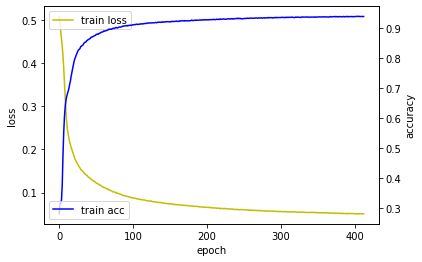

In [163]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.savefig(MODEL_SAVE_FOLDER_PATH+"/lr_"+str(learning_rate)+"_patience_"+ str(patience)+"_Loss_Acc.png")
plt.show()


In [164]:
def action_frames(y_pred_argmax, ratio_display = False):
    action_label =  {"sit": 0, "sit-stand": 1,  "walk": 2, "turn": 3,  "stand-sit": 4}
    action_cnt =  {"total_frames": 0,"sit": 0, "sit-stand": 0,  "walk": 0, "turn": 0,"stand-sit": 0}

    for i in range(len(y_pred_argmax)):
        action_cnt["total_frames"] +=1
        if y_pred_argmax[i] == action_label["sit"]:
            action_cnt["sit"] +=1
            
        elif y_pred_argmax[i] == action_label["sit-stand"]:
            action_cnt["sit-stand"] +=1
            
        elif y_pred_argmax[i] == action_label["walk"]:
            action_cnt["walk"] +=1
            
        elif y_pred_argmax[i] == action_label["turn"]:
            action_cnt["turn"] +=1
        
            
        elif y_pred_argmax[i] == action_label["stand-sit"]:
            action_cnt["stand-sit"] +=1
        
    if ratio_display:     
        print("[ Action Ratio ]")
        print("\t [ 0 - Sit] ratio of sit: ",  action_cnt["sit"]/action_cnt["total_frames"] )
        print("\t [ 1 - sit-stand] ratio of sit-stand: ",  action_cnt["sit-stand"]/action_cnt["total_frames"])
        print("\t [ 2 - walk] ratio of walk: ",  action_cnt["walk"]/action_cnt["total_frames"])
        print("\t [ 3 - turn] ratio of turn: ",  action_cnt["turn"]/action_cnt["total_frames"])
        print("\t [ 4 - stand-sit] ratio of stand-sit: ",  action_cnt["stand-sit"]/action_cnt["total_frames"])
    return action_cnt
    
    
    
y_pred = model.predict(test_x)
y_pred_onehot = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[200] ,"===> onehot: ", y_pred_onehot[200])

y_test_argmax = np.argmax(test_y ,axis=1) 
y_pred_argmax = np.argmax(y_pred ,axis=1)
print(y_test_argmax.shape, y_pred_argmax.shape)


y_pred_frames = action_frames(y_pred_argmax, ratio_display= True)
y_test_frames = action_frames(y_test_argmax,  ratio_display= True)   

print("--->  # of Each Action Frames  \n\t y_pred: {0}, \n\t y_test: {1}".format(y_pred_frames, y_test_frames))

(20588, 5)
[0.     0.     0.9901 0.0099 0.    ] ===> onehot:  2
(20588,) (20588,)
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.2753545754808626
	 [ 1 - sit-stand] ratio of sit-stand:  0.06387215853895473
	 [ 2 - walk] ratio of walk:  0.41193899358849817
	 [ 3 - turn] ratio of turn:  0.1639304449193705
	 [ 4 - stand-sit] ratio of stand-sit:  0.08490382747231397
[ Action Ratio ]
	 [ 0 - Sit] ratio of sit:  0.27253740042743346
	 [ 1 - sit-stand] ratio of sit-stand:  0.05940353604041189
	 [ 2 - walk] ratio of walk:  0.4602681173499126
	 [ 3 - turn] ratio of turn:  0.13483582669516223
	 [ 4 - stand-sit] ratio of stand-sit:  0.07295511948707985
--->  # of Each Action Frames  
	 y_pred: {'total_frames': 20588, 'sit': 5669, 'sit-stand': 1315, 'walk': 8481, 'turn': 3375, 'stand-sit': 1748}, 
	 y_test: {'total_frames': 20588, 'sit': 5611, 'sit-stand': 1223, 'walk': 9476, 'turn': 2776, 'stand-sit': 1502}


Cohens kappa: 0.884797
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5611
           1       0.80      0.86      0.83      1223
           2       0.99      0.89      0.93      9476
           3       0.81      0.99      0.89      2776
           4       0.76      0.88      0.82      1502

    accuracy                           0.92     20588
   macro avg       0.86      0.92      0.89     20588
weighted avg       0.93      0.92      0.92     20588


---> Confusion Matrix 
 [[5404  140    0    0   67]
 [ 140 1051   16    0   16]
 [   0  117 8392  631  336]
 [   0    0   32 2744    0]
 [ 125    7   41    0 1329]]


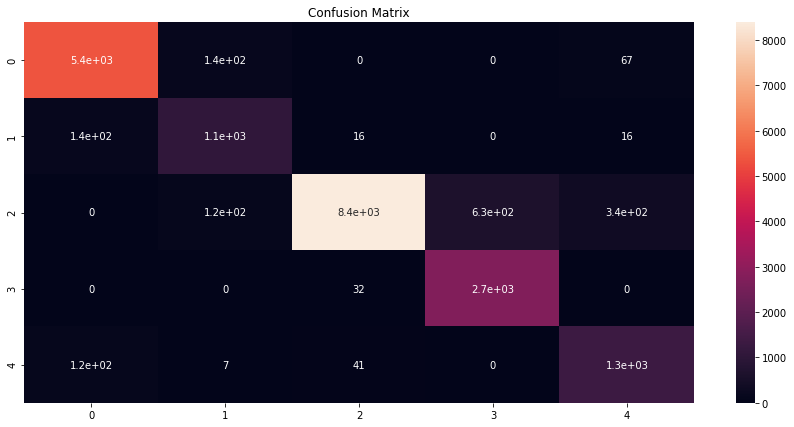

In [165]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns


kappa = cohen_kappa_score(y_test_argmax, y_pred_argmax)
print('Cohens kappa: %f' % kappa)

print(classification_report(y_test_argmax, y_pred_argmax))
conf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax)
print("\n---> Confusion Matrix \n" ,conf_matrix) # sit, sit-stand, walking, turning, stand-sit

plt.figure(figsize = (15,7) )
sns.heatmap(conf_matrix, annot=True)
plt.title("Confusion Matrix")
plt.savefig(MODEL_SAVE_FOLDER_PATH+"/pred_Confusion_Matrix.png")
plt.show()

## POST processing (DTW) 

In [166]:
from dtw import dtw
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

act_dict = {"sit":0, "sit-to-stand":1, "walk": 2, "turn": 3, "stand-to-sit":4}
answer_y = [act_dict["sit"], act_dict["sit-to-stand"], act_dict["walk"], act_dict["turn"], act_dict["walk"], act_dict["stand-to-sit"], act_dict["sit"] ]
target_names = ["sit", "sit-to-stand", "walk", "turn", "stand-to-sit"]


def post_process_DTW(pred_y, answer_y):
    dtw_index ={"walk":4, "stand-to-sit": 5, "sit": 6}
    dtw_alignment  = dtw(pred_y,answer_y, keep_internals=True)

    results =[]
    for elements in dtw_alignment.index2:
        if elements == dtw_index["walk"]: 
            elements = act_dict["walk"]
        elif elements == dtw_index["stand-to-sit"]:  #
            elements = act_dict["stand-to-sit"]
        elif elements == dtw_index["sit"]:  #
            elements =  act_dict["sit"]     
        results.append(elements)

    
    # 간혹.. dtw 결과가 1개 더 많이 나올 때 있음.. 걍 뒤에 하나 지워버려..
    if len(dtw_alignment.index2) > len(pred_y):
        new_result = results[:-1]
    else:
        new_result = results
        
    return dtw_alignment, new_result


def plot_postResults(answer_y, pred_y, results, title="dtw"):
    fig = plt.figure(figsize=(18,12))
    
    Gnd_fig = fig.add_subplot(2,3,1)
    Gnd_fig.set_title(" Ground Truth ")
    Gnd_fig.plot(answer_y, "g", label = "Ground Truth")
    plt.legend()
    
    pred_fig = fig.add_subplot(2,3,2)
    pred_fig.set_title(" Prediction Result (Before DTW) ")
    pred_fig.plot(pred_y, "b", label=" pred_y (before DTW)")
    plt.legend()
    
    dtw_fig = fig.add_subplot(2,3,3)
    dtw_fig.set_title(" PostProcessing Results (DTW) ")
    dtw_fig.plot(results, "r",  label="dtw_result")
    plt.legend()
    
    gnd_pred_fig = fig.add_subplot(2,3,4)
    gnd_pred_fig.set_title(" Comparison: Ground Truth vs Prediction")
    gnd_pred_fig.plot(answer_y, "g", label="Ground Truth") # linewidth=3
    gnd_pred_fig.plot(pred_y, "b--", label=" pred_y (before DTW)")
    plt.legend()
    
    pred_dtw_fig = fig.add_subplot(2,3,5)
    pred_dtw_fig.set_title(" Comparison: Prediction vs DTW alignment")
    pred_dtw_fig.plot(pred_y, "b--", label=" pred_y (before DTW)") # linewidth=3
    pred_dtw_fig.plot(results, "r", label=" dtw_result")
    plt.legend()
    
    gnd_dtw_fig = fig.add_subplot(2,3,6)
    gnd_dtw_fig.set_title(" Comparison: Ground Truth vs DTW alignment ")
    gnd_dtw_fig.plot(answer_y, "g--", label="Ground Truth")
    gnd_dtw_fig.plot(results, "r", label="dtw_result")  # linewidth=3
    
    plt.legend()
    plt.savefig(MODEL_SAVE_FOLDER_PATH+"/DTW_Comparison_" + title  + ".png")
    
def create_testdata(pelvis_csv, lookback_window = 8):
    test_x = np.zeros((0, lookback_window, numPelvis,1 ))
    test_y = np.zeros((0, numActions)) 
    
   
    timstamp_ms, lpfPelvis_x, lpfPelvis_y, lpfPelvis_z, oneHot_actionList  = getLPF_PelvisData(pelvis_csv)  # raw                 
    
    pelvisData = np.array([lpfPelvis_x, lpfPelvis_y, lpfPelvis_z]).T  # (335,3) 
    actionData = np.array(oneHot_actionList)    # # (335, 5)
                            
    blockTime, blockPelvis, blockLable, enc = sliding_window(timstamp_ms, data_x = pelvisData, data_y = actionData, lookback_window=lookback_window) 

    test_x = np.append(test_x, blockPelvis, axis = 0 )
    test_y = np.append(test_y, blockLable, axis = 0 )    

    return test_x, test_y

### 정상인 20대, 30대, 60대 

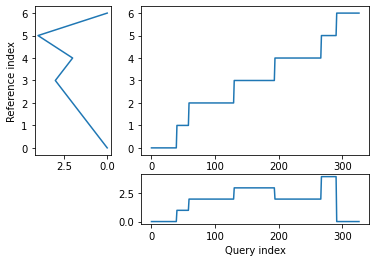

1/1 - 0s - loss: 0.0829 - accuracy: 0.9725
[Before DTW] Before_DTW_Norm_20 
               precision    recall  f1-score   support

         sit       0.97      0.99      0.98        76
sit-to-stand       0.94      0.89      0.92        19
        walk       0.97      0.99      0.98       144
        turn       1.00      0.94      0.97        64
stand-to-sit       0.96      0.96      0.96        24

    accuracy                           0.97       327
   macro avg       0.97      0.95      0.96       327
weighted avg       0.97      0.97      0.97       327

------------------------------

[After DTW] After_DTW_Norm_20 
               precision    recall  f1-score   support

         sit       1.00      1.00      1.00        76
sit-to-stand       1.00      1.00      1.00        19
        walk       1.00      1.00      1.00       144
        turn       1.00      1.00      1.00        64
stand-to-sit       1.00      1.00      1.00        24

    accuracy                           1.00 

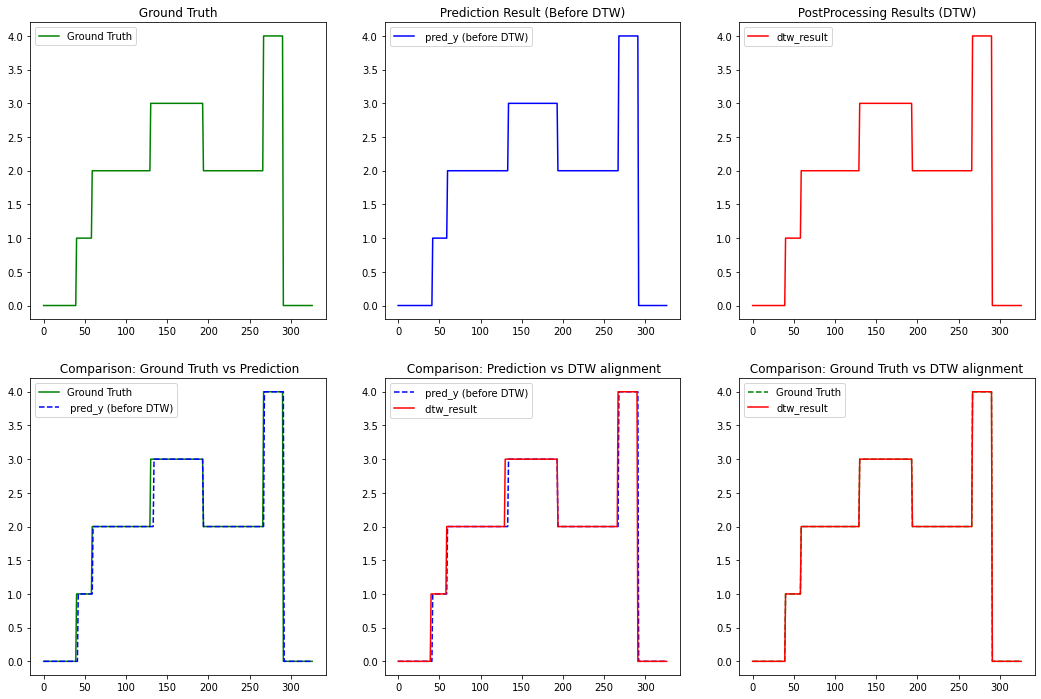

In [167]:
test_normal_20 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_11_03 TUG/bys_tug/001/Originact5_lpf_labeled_bys_tug_001.csv"
test_normal_20_x, test_normal_20_y_onehot = create_testdata(test_normal_20) 
test_normal_20_y = np.argmax(test_normal_20_y_onehot, axis=1).reshape(-1) # GND one-hot decode

pred_normal_20_y_onehot = model.predict(test_normal_20_x) 
pred_normal_20_y = np.argmax(pred_normal_20_y_onehot, axis=1) #  # pred one-hot decode

normal_20_alignment, normal_20_results = post_process_DTW(test_normal_20_y, answer_y)
normal_20_alignment.plot(type="threeway")
plot_postResults(test_normal_20_y, pred_normal_20_y, normal_20_results, title="normal_20")

# ----- [Before DTW] Model Test
norm_20_eval = model.evaluate(test_normal_20_x, test_normal_20_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_20.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_20 \n", classification_report(test_normal_20_y, pred_normal_20_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_20 \n", classification_report(test_normal_20_y, normal_20_results, target_names=target_names))

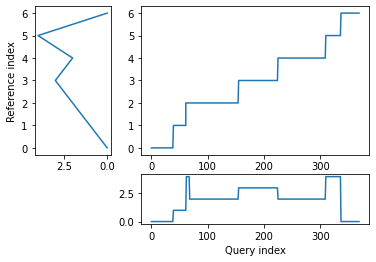

1/1 - 0s - loss: 0.1480 - accuracy: 0.9432
[Before DTW] Before_DTW_Norm_30 
               precision    recall  f1-score   support

         sit       0.96      1.00      0.98        69
sit-to-stand       0.91      0.91      0.91        23
        walk       1.00      0.91      0.95       190
        turn       0.94      1.00      0.97        66
stand-to-sit       0.64      0.95      0.76        22

    accuracy                           0.94       370
   macro avg       0.89      0.95      0.92       370
weighted avg       0.96      0.94      0.95       370

------------------------------

[After DTW] After_DTW_Norm_30 
               precision    recall  f1-score   support

         sit       0.97      1.00      0.99        69
sit-to-stand       0.91      0.91      0.91        23
        walk       0.99      0.94      0.96       190
        turn       0.93      0.98      0.96        66
stand-to-sit       0.81      1.00      0.90        22

    accuracy                           0.96 

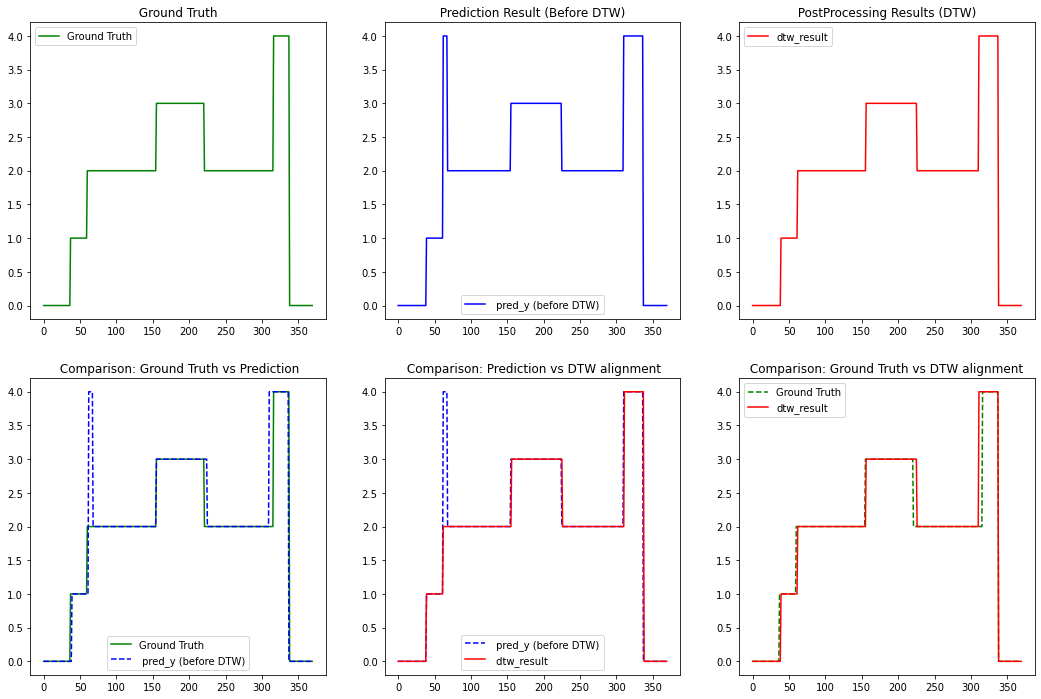

In [168]:
test_normal_30 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_11_20_v2 TUG/cyj2/03/Originact5_lpf_labeled_cyj2_03.csv"
test_normal_30_x, test_normal_30_y_onehot = create_testdata(test_normal_30) 
test_normal_30_y = np.argmax(test_normal_30_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_normal_30_onehot = model.predict(test_normal_30_x)
pred_normal_30_y = np.argmax(pred_normal_30_onehot, axis=1)

normal_30_alignment, normal_30_results = post_process_DTW(pred_normal_30_y, answer_y)
normal_30_alignment.plot(type="threeway")
plot_postResults(test_normal_30_y, pred_normal_30_y, normal_30_results, title="normal_30")

# ----- [Before DTW] Model Test

norm_30_eval = model.evaluate(test_normal_30_x, test_normal_30_y_onehot,batch_size= batch_size,verbose=2)


report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_30.txt",'w+t')
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before_DTW_Norm_30 \n", classification_report(test_normal_30_y, pred_normal_30_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_30 \n", classification_report(test_normal_30_y, normal_30_results, target_names=target_names))

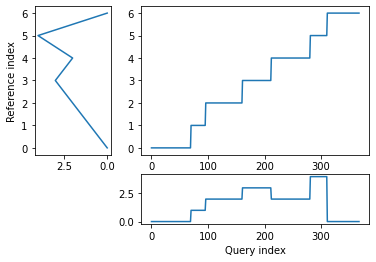

1/1 - 0s - loss: 0.1210 - accuracy: 0.9457
[Before DTW] Before DTW Norm 60 
               precision    recall  f1-score   support

         sit       1.00      0.91      0.95       139
sit-to-stand       0.69      1.00      0.82        18
        walk       1.00      0.94      0.97       142
        turn       0.88      1.00      0.94        45
stand-to-sit       0.80      1.00      0.89        24

    accuracy                           0.95       368
   macro avg       0.87      0.97      0.91       368
weighted avg       0.96      0.95      0.95       368

------------------------------

[After DTW] After_DTW_Norm_60 
               precision    recall  f1-score   support

         sit       1.00      0.91      0.95       139
sit-to-stand       0.69      1.00      0.82        18
        walk       1.00      0.94      0.97       142
        turn       0.88      1.00      0.94        45
stand-to-sit       0.80      1.00      0.89        24

    accuracy                           0.95 

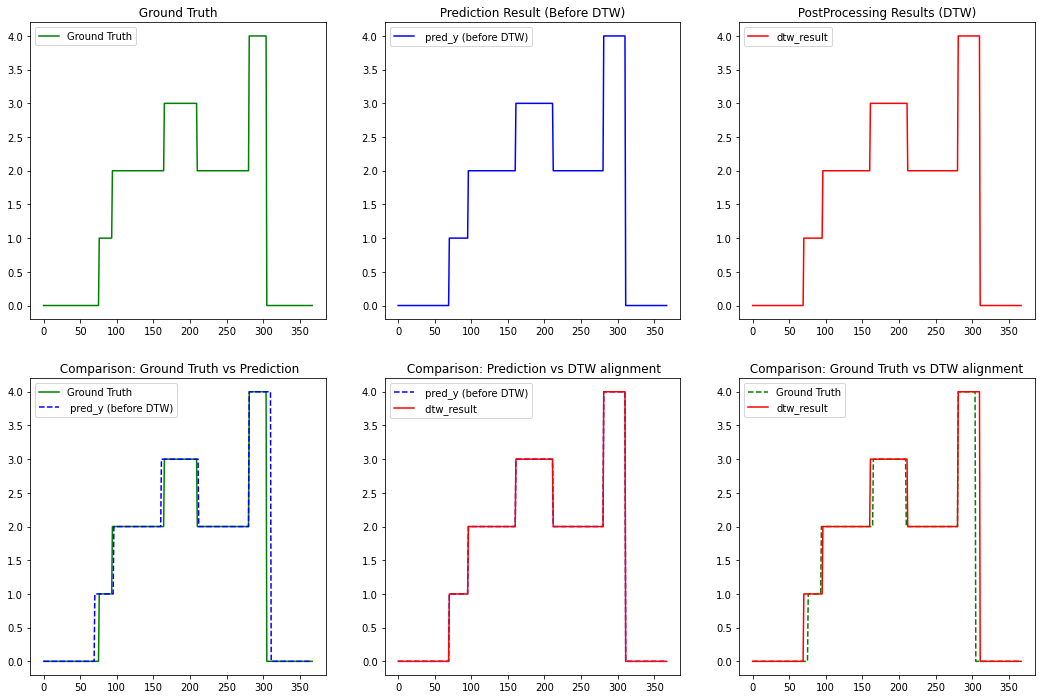

In [169]:
test_normal_60 = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_02_09 TUG/UMS_TUG/05/Originact5_lpf_labeled_UMS_TUG_05.csv"
test_normal_60_x, test_normal_60_y_onehot = create_testdata(test_normal_60) 
test_normal_60_y = np.argmax(test_normal_60_y_onehot, axis=1).reshape(-1) # one-hot decode


pred_normal_60_onehot = model.predict(test_normal_60_x)
pred_normal_60_y = np.argmax(pred_normal_60_onehot, axis=1).reshape(-1) 

normal_60_alignment, normal_60_results = post_process_DTW(pred_normal_60_y, answer_y)
normal_60_alignment.plot(type="threeway")
plot_postResults(test_normal_60_y, pred_normal_60_y, normal_60_results, title="normal_60")


# ----- [Before DTW] Model Test
norm_60_eval = model.evaluate(test_normal_60_x, test_normal_60_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_Norm_60.txt",'w+t')
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names), file = report_dtw)
print("------------------------------\n",file = report_dtw)
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names), file =   report_dtw)
report_dtw.close()


# ----------- Visualize in cell
print("[Before DTW] Before DTW Norm 60 \n", classification_report(test_normal_60_y, pred_normal_60_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After_DTW_Norm_60 \n", classification_report(test_normal_60_y, normal_60_results, target_names=target_names))

###  Stroke -- 보조필요 없는 수준의 편마비, 케인/지팡이 사용,  모방 보행

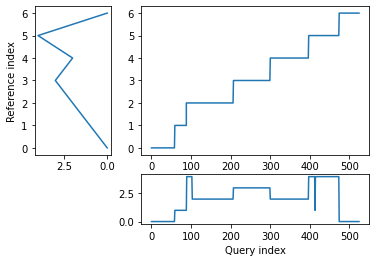

2/2 - 0s - loss: 0.5073 - accuracy: 0.8190
[Before DTW] Before DTW stroke_1 
               precision    recall  f1-score   support

         sit       0.92      1.00      0.96       101
sit-to-stand       0.97      0.79      0.87        38
        walk       1.00      0.71      0.83       283
        turn       0.62      1.00      0.77        58
stand-to-sit       0.44      0.89      0.59        45

    accuracy                           0.82       525
   macro avg       0.79      0.88      0.80       525
weighted avg       0.89      0.82      0.83       525

------------------------------

[After DTW] After DTW stroke_1 
               precision    recall  f1-score   support

         sit       0.93      1.00      0.96       101
sit-to-stand       1.00      0.79      0.88        38
        walk       0.98      0.75      0.85       283
        turn       0.62      1.00      0.77        58
stand-to-sit       0.53      0.91      0.67        45

    accuracy                           0.8

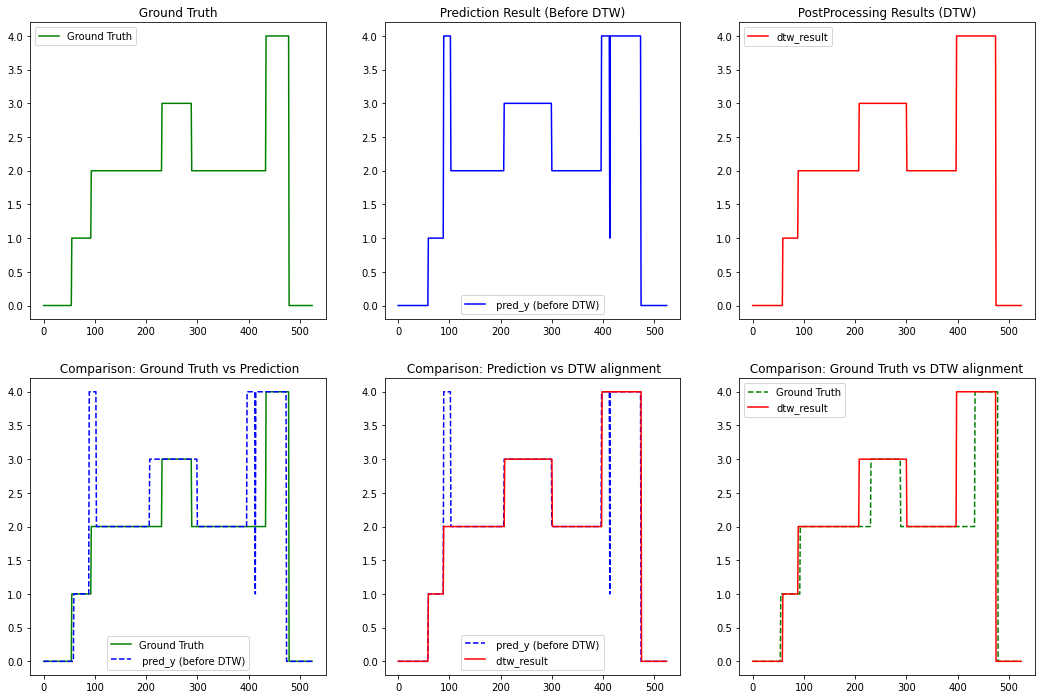

In [170]:
test_stroke_1 =  "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_12_09 TUG/JDW_tug/01/Originact5_lpf_labeled_JDW_tug_01.csv"
test_stroke_1_x, test_stroke_1_y_onehot = create_testdata(test_stroke_1)  
test_stroke_1_y = np.argmax(test_stroke_1_y_onehot, axis=1).reshape(-1) # one-hot decode

pred_stroke_1_one_hot = model.predict(test_stroke_1_x)
pred_stroke_1_y = np.argmax(pred_stroke_1_one_hot, axis=1)

stroke_1_alignment, stroke_1_results = post_process_DTW(pred_stroke_1_y, answer_y)

stroke_1_alignment.plot(type="threeway")
plot_postResults(test_stroke_1_y, pred_stroke_1_y, stroke_1_results, title="stroke_1")


# # ----- [Before DTW] Model Test
stroke_1_eval = model.evaluate(test_stroke_1_x, test_stroke_1_y_onehot, batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_1.txt",'w+t')
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_1 \n", classification_report(test_stroke_1_y, pred_stroke_1_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After DTW stroke_1 \n", classification_report(test_stroke_1_y, stroke_1_results, target_names=target_names))

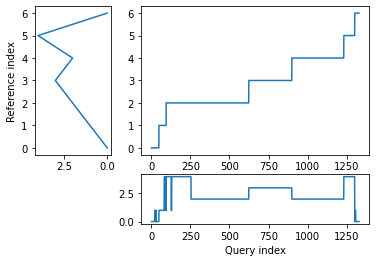

3/3 - 0s - loss: 0.4048 - accuracy: 0.8107
[Before DTW] Before DTW stroke_tool 
               precision    recall  f1-score   support

         sit       0.86      0.92      0.89        62
sit-to-stand       0.81      0.30      0.44       147
        walk       1.00      0.84      0.91       840
        turn       0.80      1.00      0.89       220
stand-to-sit       0.24      0.89      0.37        62

    accuracy                           0.81      1331
   macro avg       0.74      0.79      0.70      1331
weighted avg       0.90      0.81      0.83      1331

------------------------------
 
[After DTW] After DTW stroke_tool 
               precision    recall  f1-score   support

         sit       0.83      1.00      0.91        62
sit-to-stand       1.00      0.32      0.48       147
        walk       0.89      0.92      0.90       840
        turn       0.80      1.00      0.89       220
stand-to-sit       0.80      0.90      0.85        62

    accuracy                       

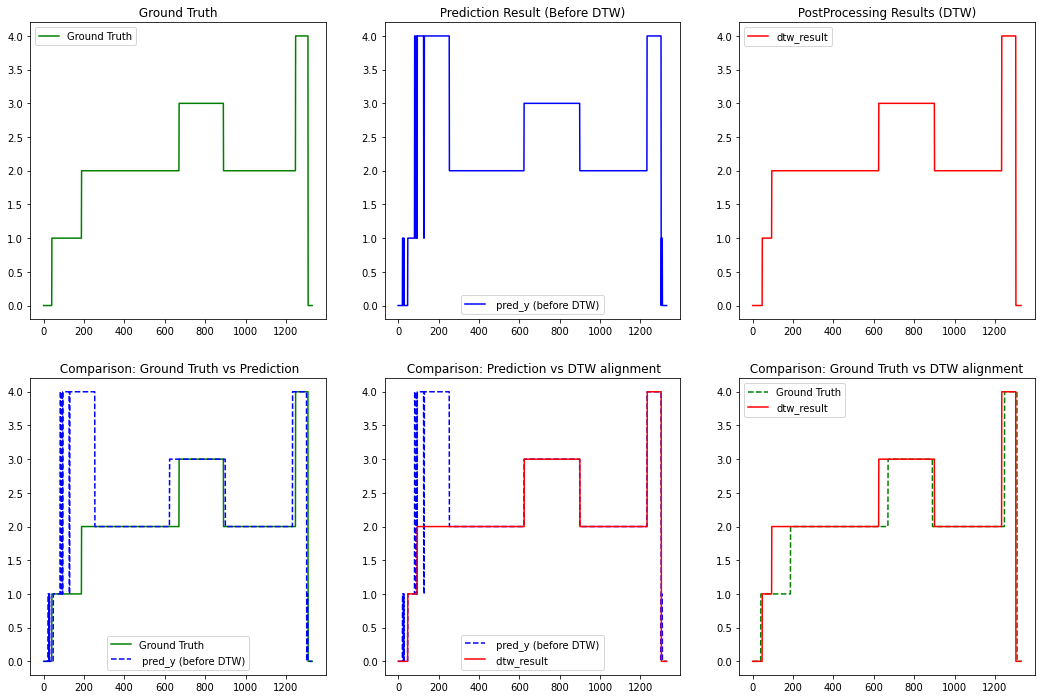

In [171]:
test_stroke_tool = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2021_01_20 TUG/KSG_TUG/02/Originact5_lpf_labeled_KSG_TUG_02.csv"
test_stroke_tool_x, test_stroke_tool_y_onehot = create_testdata(test_stroke_tool) 
test_stroke_tool_y = np.argmax(test_stroke_tool_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_stroke_tool_onehot = model.predict(test_stroke_tool_x)
pred_stroke_tool_y = np.argmax(pred_stroke_tool_onehot, axis=1)

stroke_tool_alignment, stroke_tool_results = post_process_DTW(pred_stroke_tool_y, answer_y)
stroke_tool_alignment.plot(type="threeway")
plot_postResults(test_stroke_tool_y, pred_stroke_tool_y, stroke_tool_results, title="stroke_tool")


# ----- [Before DTW] Model Test
stroke_tool_eval = model.evaluate(test_stroke_tool_x, test_stroke_tool_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_stroke_tool.txt",'w+t')
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names), file = report_dtw)
print("------------------------------\n ", file = report_dtw)
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names), file = report_dtw)
report_dtw.close()

# ----------- Visualize in cell
print("[Before DTW] Before DTW stroke_tool \n", classification_report(test_stroke_tool_y, pred_stroke_tool_y, target_names=target_names))
print("------------------------------\n ")
print("[After DTW] After DTW stroke_tool \n", classification_report(test_stroke_tool_y, stroke_tool_results, target_names=target_names))


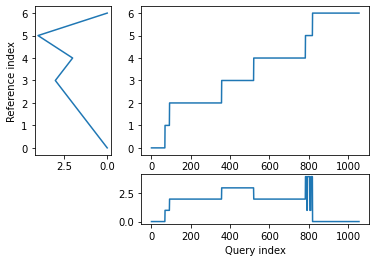

3/3 - 0s - loss: 0.3466 - accuracy: 0.8835
[Before DTW] Before DTW copy_stroke 
               precision    recall  f1-score   support

         sit       0.96      1.00      0.98       294
sit-to-stand       0.72      0.53      0.61        43
        walk       0.91      0.90      0.90       537
        turn       0.66      1.00      0.80       108
stand-to-sit       1.00      0.35      0.52        74

    accuracy                           0.88      1056
   macro avg       0.85      0.76      0.76      1056
weighted avg       0.90      0.88      0.88      1056

------------------------------

[After DTW] After DTW copy_stroke 
               precision    recall  f1-score   support

         sit       0.96      1.00      0.98       294
sit-to-stand       1.00      0.53      0.70        43
        walk       0.91      0.90      0.91       537
        turn       0.66      1.00      0.80       108
stand-to-sit       1.00      0.49      0.65        74

    accuracy                        

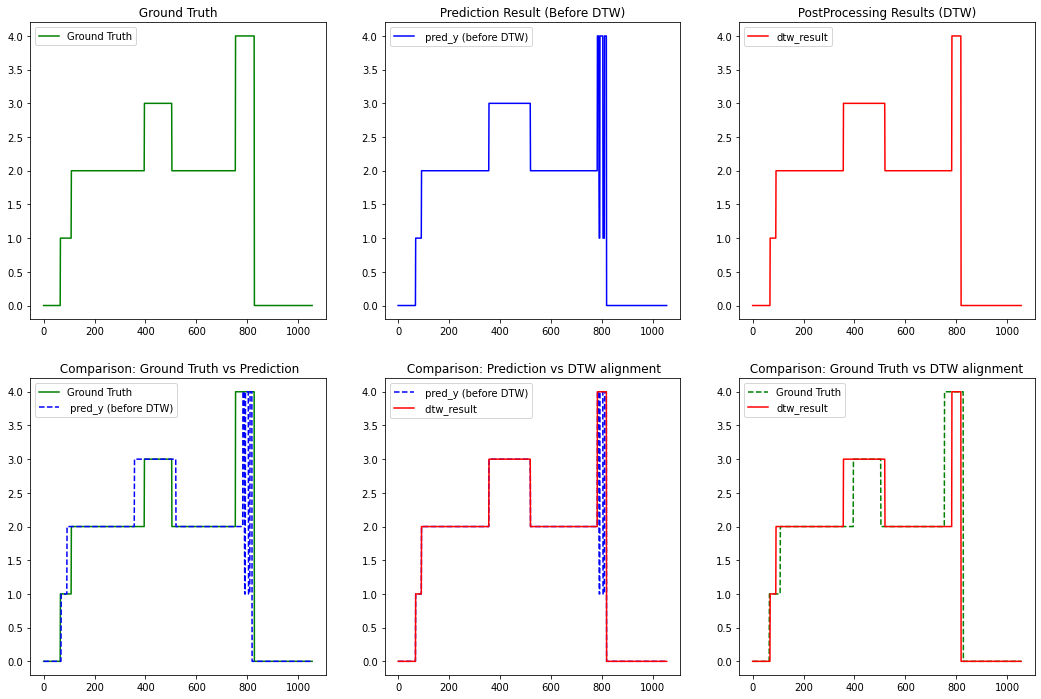

In [172]:
test_copy_stroke = "/DockerProjects/Dataset/TUG/trainSet/HMM_saveResults_최윤정/0_sideView/2020_12_30 TUG/YSJ_TUG/03/Originact5_lpf_labeled_YSJ_TUG_03.csv"
test_copy_stroke_x, test_copy_stroke_y_onehot = create_testdata(test_copy_stroke) 
test_copy_stroke_y = np.argmax(test_copy_stroke_y_onehot, axis=1).reshape(-1) #one-hot decode

pred_copy_stroke_onehot = model.predict(test_copy_stroke_x)
pred_copy_stroke_y = np.argmax(pred_copy_stroke_onehot, axis=1)


copy_stroke_alignment, copy_stroke_results = post_process_DTW(pred_copy_stroke_y, answer_y)
copy_stroke_alignment.plot(type="threeway")
plot_postResults(test_copy_stroke_y, pred_copy_stroke_y, copy_stroke_results, title="copy_stroke")


# ----- [Before DTW] Model Test
copy_stroke_eval = model.evaluate(test_copy_stroke_x, test_copy_stroke_y_onehot,batch_size= batch_size,verbose=2)

report_dtw = open(MODEL_SAVE_FOLDER_PATH + "/Comp_DTW_copy_stroke.txt",'w+t')
print("[Before DTW] Before DTW copy_stroke \n", classification_report(test_copy_stroke_y, pred_copy_stroke_y, target_names=target_names), file = report_dtw)
print("------------------------------\n", file = report_dtw)
print("[After DTW] After DTW copy_stroke \n", classification_report(test_copy_stroke_y, copy_stroke_results, target_names=target_names), file = report_dtw)
report_dtw.close()


# ----------- Visualize in cell
print("[Before DTW] Before DTW copy_stroke \n", classification_report(test_copy_stroke_y, pred_copy_stroke_y, target_names=target_names))
print("------------------------------\n")
print("[After DTW] After DTW copy_stroke \n", classification_report(test_copy_stroke_y, copy_stroke_results, target_names=target_names))

train_ratio = 0.6
valid_ratio = 0.2

shuffle = True
arbitrarySplit = False
Kfold = True
Kfold_num = 5 # if kfold_num = 0 (arbitrary train/test set will be used)s


numFeature = 4 # time + numPelvis = 4
numPelvis = 3 
numActions = 5
dataset_columns = numFeature + numActions

subList, numOfsubjects = get_subjectList(datasetDir, shuffle = shuffle) ; print("\n")

if arbitrarySplit is not True:
    if Kfold:
        print(" K-fold : ", Kfold_num)
        trainFold, testFold = fold_trainNames(subList = subList, Kfold_num = Kfold_num)

        selected_foldNum = 0 

        train_subjects = trainFold[selected_foldNum]
        test_subjects = testFold[selected_foldNum]
        print("\t ------>  Selected Fold num: %d \n   Train Subjects: %s\n   Test Subjects: %s"%(selected_foldNum, train_subjects, test_subjects))
    else:

        trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
        validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
        testSub_number = numOfsubjects - trainSub_number - validSub_number

        train_subjects = subList[ :trainSub_number]
        valid_subjects = subList[ trainSub_number : (trainSub_number+validSub_number)]
        test_subjects = subList[ (trainSub_number+validSub_number): ]
        print("   No-fold \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)
        print("\n\t--> # of train  : " + str(trainSub_number) +" 명 ,  # of valid : "+ str(validSub_number) + " 명 ,  # of test :" + str(testSub_number) + "명")

else:

                # 정상인 (20-40대) --- 17명, 166 Trials (중복 3명 빼면 14명, 138 Trials )
                # ['bys_tug', 'cyj_tug', 'cbd_tug', 'kw' , 'pjh',     'pss', 'yjh', 'kyh' , 'lhs', 'nhs',    'bys', 'cyj', 'cbd', 'cyj2', 'jdh',   'jet', 'kch']
            
            
                # 정상인 (50-70대)  ---- 총 31명  227 Trials 
                # ['rjh', 'NHJ_60', 'YJY_TUG'(0), 'LKO_TUG', 'LSJ_TUG',    'GYH_TUG', 'KYS3_TUG','PBK_TUG','KJK_TUG', 'WHS_TUG'(0),    'UMS_TUG','JJS_TUG','HOJ_TUG','SJJ_TUG','YSS2_TUG',   'KJH_TUG','CSY_TUG','LBL_TUG','UKO_TUG'(0), 'BKS_TUG', 
                # 'LSC_TUG','YMR_TUG','PSM_TUG','HSN_TUG','SOS_TUG',     'LSS_TUG', 'KDS_TUG'(0), 'KHM_TUG', 'LJS_TUG', 'LJE_TUG',     'KBH_TUG' ]


                # 뇌졸중 (연령 X) --- 총 20 명 , 85 Trials
                # [  'BGD_TUG'(0), 'KNG_TUG', 'KSG_TUG', 'YBJ_TUG', 'RJD_TUG',    'YSS_TUG'(0), 'SRK_TUG', 'KWB_TUG'(0), 'KYS_TUG', 'KTS_TUG',    'SRH_TUG', 'YDS_TUG'(0)', 'HHS_TUG', 'KYS2_TUG', 'KSJ_TUG',      
                #    'KYB_TUG', 'CES_TUG', 'PCW_TUG', 'WJS_TUG','HKH_TUG',        'HJY_TUG', 'SHW_TUG']
    
    
    norm20 = ['bys_tug', 'cyj_tug', 'cbd_tug', 'kw' , 'pjh',     'pss', 'yjh', 'kyh' , 'lhs', 'nhs',    'bys', 'cyj', 'cbd', 'cyj2', 'jdh',   'jet', 'kch']
    norm60 = ['rjh', 'NHJ_60', 'LKO_TUG', 'LSJ_TUG',    'GYH_TUG', 'KYS3_TUG','PBK_TUG','KJK_TUG', 'UMS_TUG','JJS_TUG',   'HOJ_TUG','SJJ_TUG','YSS2_TUG',   'KJH_TUG','CSY_TUG','LBL_TUG','BKS_TUG', 
              'LSC_TUG','YMR_TUG','PSM_TUG','HSN_TUG','SOS_TUG',     'LSS_TUG', 'KHM_TUG', 'LJS_TUG', 'LJE_TUG',     'KBH_TUG' ]
    stroke = ['KNG_TUG', 'KSG_TUG', 'YBJ_TUG', 'RJD_TUG',  'SRK_TUG',     'KYS_TUG', 'KTS_TUG','SRH_TUG', 'HHS_TUG', 'KYS2_TUG',      'KSJ_TUG', 'KYB_TUG', 'CES_TUG', 'PCW_TUG', 'WJS_TUG',
              'HKH_TUG', 'HJY_TUG', 'SHW_TUG']
    
    specific_group = norm20 # -------------------------------------------------- Change This part 
    numOfsubjects = len( specific_group )
    
    
    np.random.shuffle(specific_group)
    
    trainSub_number = np.round( (numOfsubjects*train_ratio), 0).astype(int)
    validSub_number = np.round( (numOfsubjects*valid_ratio), 0).astype(int)
    testSub_number = numOfsubjects - trainSub_number - validSub_number

    train_subjects = specific_group[ :trainSub_number]
    valid_subjects = specific_group[ trainSub_number : (trainSub_number+validSub_number)]
    test_subjects = specific_group[ (trainSub_number+validSub_number): ]
    
    print(" No-fold --- (arbitrary) \t [results] \n\t Train 명: " ,len(train_subjects), "\n\t Valid 명: ", len(valid_subjects), "\n\t Test 명: ", len(test_subjects))
    print(" No-fold --- (arbitrary) \t [results] \n\t Train: " ,train_subjects, "\n\t Valid: ", valid_subjects, "\n\t Test: ", test_subjects)